<a href="https://colab.research.google.com/github/mezkymy/diabetes-prediction/blob/resimplified/Diabetes_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, FunctionTransformer

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, jaccard_score, log_loss, confusion_matrix
from sklearn.model_selection import train_test_split, cross_validate, learning_curve
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [3]:
# set random state for consistency on random methods results
random_state = 22

# Diabetes Prediction Model

Data Source: https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset

<b>Context (copied from Kaggle):</b>

The Diabetes prediction dataset is a collection of medical and demographic data from patients, along with their diabetes status (positive or negative). The data includes features such as age, gender, body mass index (BMI), hypertension, heart disease, smoking history, HbA1c level, and blood glucose level. This dataset can be used to build machine learning models to predict diabetes in patients based on their medical history and demographic information. This can be useful for healthcare professionals in identifying patients who may be at risk of developing diabetes and in developing personalized treatment plans. Additionally, the dataset can be used by researchers to explore the relationships between various medical and demographic factors and the likelihood of developing diabetes.

In [4]:
# load data
raw_data = pd.read_csv('https://raw.githubusercontent.com/mezkymy/diabetes-prediction/main/diabetes_prediction_dataset.csv')
df = raw_data.copy()
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [5]:
# check columns info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [6]:
# descriptive statisics for numerical type
df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


In [7]:
# descriptive statisics for object type
df.select_dtypes(['object']).describe()

,gender,smoking_history
count,100000,100000
unique,3,6
top,Female,No Info
freq,58552,35816


For string/categorical columns, there are only a few unique values on each column. For modeling purposes, using One-hot encoding should be viable for both columns.

# Exploratory Data Analysis

## Distribution Based on Numerical Features

In [8]:
# # show scatter plots between numerical columns
# sns.pairplot(df, hue='diabetes', plot_kws={"s": 3})
# plt.show()

Based on the pair plot above, we can gather some insights visually:
1. As stated in the data source, blood glucose level is one of the key indicator of diabetes. It is proven by visually looking at the distribution based on hue, where above 200 there are no patients that are not diagnosed with diabetes, while only a relatively small portion of patients with lower than 200 blood glucose level are diagnosed with diabetes
2. Furthermore, HbA1c_level or the measure of a person's average blood sugar level over the past 2-3 months segments patients even more, where those with blood glucose level somewhere between 100-150 but also with HbA1c level above ~7 are diagnosed with diabetes. This seperates the small portion of patients mentioned on point 1
3. No patients with blood glucose level above 200 have a HbA1c level of below ~5. At the same time, no patients with lower than ~125 blood glucose level have a HbA1c level of above ~7. Since blood glucose level are measured at a given time while HbA1c are measured on average over the past 2-3 months, this shows that both features are indeed correlated to each other, although blood glucose level at a given time might change drastically compared to its average over 2-3 months
4. Judging visually, a higher age means a higher risk of having diabetes, while hypertension and heart disease does not always indicate diabetes. Body mass index also are not visually correlated to diabetes
5. BMI are either heavily skewed, or there are some outliers that might need to be treated or removed

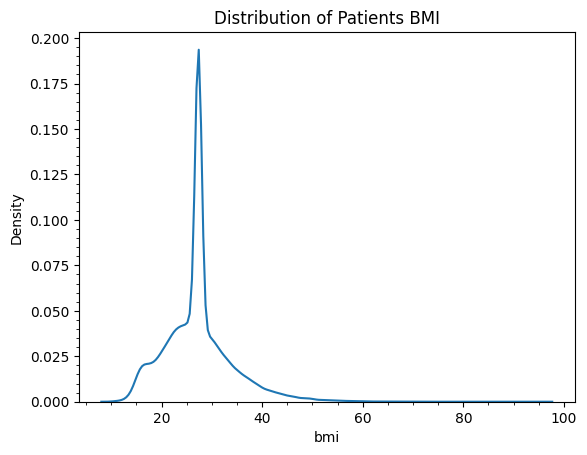

In [9]:
# check bmi distribution with box plot
sns.kdeplot(data=df, x="bmi").set(title="Distribution of Patients BMI")

plt.minorticks_on()
plt.show()

As seen on the graph above, BMI is positively skewed, where the majority of patient's BMI are on the range of 20 to 40 but with some having up to 100. Rather than having to remove several outliers, it might be better to transform BMI with log transformation, hopefully to show a more normal distribution of BMI. 

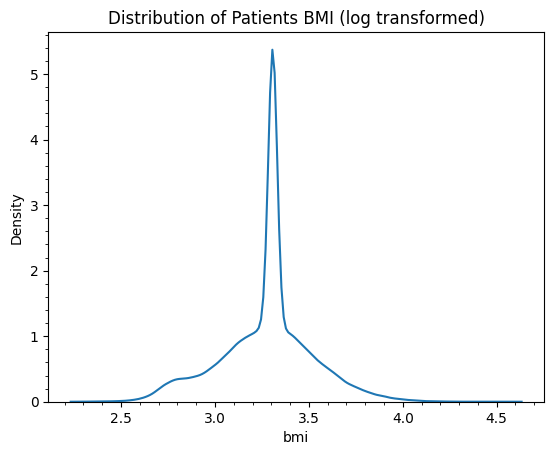

In [10]:
# try to plot log of BMI
sns.kdeplot(data=df, x=np.log(df['bmi'])).set(title="Distribution of Patients BMI (log transformed)")

plt.minorticks_on()
plt.show()

After a log transformation, BMI seems to be quite normally distributed and also may not require any outlier removal. Log transformation will be applied to BMI at the pipeline to prevent data leakage when splitting train and test data.

In [11]:
# check max level of HbA1c and blood_glucose_level on non-diabetes patients
df[df['diabetes'] == 0].describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,91500.000000,91500.000000,91500.000000,91500.000000,91500.000000,91500.000000,91500.0
mean,40.115187,0.058984,0.029235,26.887163,5.396761,132.852470,0.0
std,22.306005,0.235595,0.168465,6.373406,0.971628,34.247281,0.0
min,0.080000,0.000000,0.000000,10.010000,3.500000,80.000000,0.0
25%,22.000000,0.000000,0.000000,23.240000,4.800000,100.000000,0.0
50%,40.000000,0.000000,0.000000,27.320000,5.800000,140.000000,0.0
75%,57.000000,0.000000,0.000000,28.870000,6.200000,158.000000,0.0
max,80.000000,1.000000,1.000000,95.690000,6.600000,200.000000,0.0


In [12]:
# check max level of HbA1c and blood_glucose_level on diabetes patients
df[df['diabetes'] == 1].describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.0
mean,60.946588,0.245647,0.149059,31.988382,6.934953,194.094706,1.0
std,14.549880,0.430496,0.356167,7.558371,1.076562,58.641111,0.0
min,3.000000,0.000000,0.000000,10.980000,5.700000,126.000000,1.0
25%,52.000000,0.000000,0.000000,27.320000,6.100000,145.000000,1.0
50%,62.000000,0.000000,0.000000,29.970000,6.600000,160.000000,1.0
75%,72.000000,0.000000,0.000000,35.912500,7.500000,240.000000,1.0
max,80.000000,1.000000,1.000000,88.720000,9.000000,300.000000,1.0


Based on blood glucose level and HbA1c level, we can categorize patients into two categories:

1. Patients with HbA1c level 6.6 and below, AND with blood glucose level 200 and below, shall be categorized as category A. Patients on this category should be mostly diabetes-free
2. Other patients should be categorized as category A, where patients are diagnosed with diabetes

Since there are only two categories, a binary column would be sufficient to categorize patients based on this criterias.

In [13]:
# categorize glucose level
df['glucose_level_risk'] = np.where((df['blood_glucose_level'] <= 200) & (df['HbA1c_level'] <= 6.6), 0, 1)
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,glucose_level_risk
0,Female,80.0,0,1,never,25.19,6.6,140,0,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0,0
2,Male,28.0,0,0,never,27.32,5.7,158,0,0
3,Female,36.0,0,0,current,23.45,5.0,155,0,0
4,Male,76.0,1,1,current,20.14,4.8,155,0,0


In [14]:
df[df['glucose_level_risk'] == 0]['diabetes'].mean()

0.029826216958425668

In [15]:
df[df['glucose_level_risk'] == 1]['diabetes'].mean()

1.0

Based on its mean/average value, it can be deducted that even if a patient have lower than 200 blood glucose level and 6.6 HbA1c level, they can still be diagnosed with diabetes albeit with a relatively low chance. Patients that exceeds any of those levels however are guaranteed to be diagnosed with diabetes.

In [16]:
# check patients with 0 level risk but diagnosed with diabetes
df[(df['glucose_level_risk'] == 0) & (df['diabetes'] == 1)]

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,glucose_level_risk
6,Female,44.0,0,0,never,19.31,6.5,200,1,0
26,Male,67.0,0,1,not current,27.32,6.5,200,1,0
96,Female,67.0,0,0,never,27.32,6.2,159,1,0
242,Male,57.0,1,1,not current,27.77,6.6,160,1,0
253,Female,64.0,0,0,never,27.32,6.2,155,1,0
...,...,...,...,...,...,...,...,...,...,...
99694,Female,39.0,0,0,never,32.04,5.7,200,1,0
99723,Male,61.0,1,1,former,35.78,6.0,145,1,0
99829,Male,58.0,0,0,former,32.38,6.6,159,1,0
99845,Female,43.0,1,0,never,34.21,6.5,160,1,0


## Distribution Based on Categorical Features

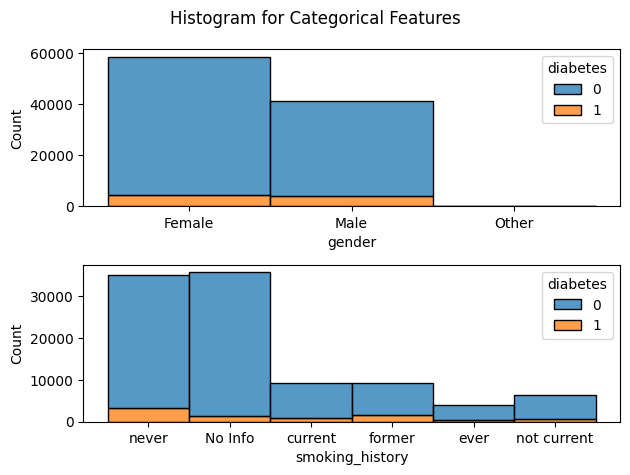

In [17]:
# Create histplot for categorical columns
cat_columns = list(df.select_dtypes(['object']).columns.values)

fig, axes = plt.subplots(2, 1)

i = 0
for ax in axes:
    col = cat_columns[i]
    sns.histplot(df, x=col, hue='diabetes', multiple='stack', ax=ax)
    i += 1

plt.suptitle('Histogram for Categorical Features')
plt.tight_layout()
plt.show()

Visually speaking, the number of males diagnosed with diabetes are identical with females, but the number of males not diagnosed with diabetes are significantly lower, which might lead to the assumption that males have a higher risk of being diagnosed with diabetes.

In [18]:
# check the amount of 'others' gender
others_count = df[df['gender'] == 'Other'].shape[0]
print(f"Number of patients with 'Other' gender: {others_count}")

Number of patients with 'Other' gender: 18


Since there are only 18 patients that are labeled with 'Other' gender, this might lead to a low predictive power model when it comes to this gender category. Thus, these 18 entries are for now dropped from the dataset.

In [19]:
df = df[df['gender'] != 'Other']
df.gender.unique()

array(['Female', 'Male'], dtype=object)

For smoking history, it might be easier to obtain insights by looking at the ratios instead of the count.

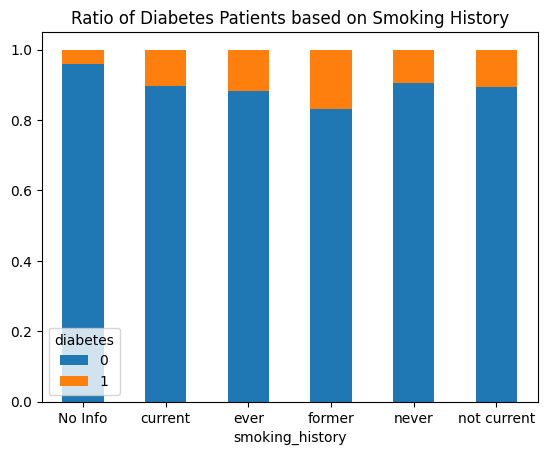

In [20]:
ct = pd.crosstab(index=df['smoking_history'],columns=df['diabetes'], normalize='index')

ct.plot(kind='bar', rot=0, stacked=True)

plt.title('Ratio of Diabetes Patients based on Smoking History')
plt.show()

Although those who have never smoked might have a lower chance of being diagnosed with diabetes (excluding those without info), those who are on the former category seems to be more susceptible to diabetes than even those who are still actively smoking. 

This might be due to the amount of smoking that is actually related to diabetes (for example, those who are on the former category smoked way more on the past than those who are still smoking currently), or that smoking history does not have a strong, significant correlation to diabetes.

Because "No Info" means that the patient might fall into any of the other categories and the number of patients having no info on their smoking history are too large, it might be better to drop this feature, as including it as is might lead to bias, where the actual ratios of each category might not be as presented on the chart above.

If the relationship between smoking history and diabetes are proven scientifically, then a stricter data collection process must be ensured to minimize the number of patients with no info on their smoking history.

In [21]:
# drop smoking_history column
df.drop(columns='smoking_history', inplace=True)
df.head()

,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,glucose_level_risk
0,Female,80.0,0,1,25.19,6.6,140,0,0
1,Female,54.0,0,0,27.32,6.6,80,0,0
2,Male,28.0,0,0,27.32,5.7,158,0,0
3,Female,36.0,0,0,23.45,5.0,155,0,0
4,Male,76.0,1,1,20.14,4.8,155,0,0


## Correlation Matrix

Since at this point gender is still an object column, we can create a temporary dataframe which encodes gender with a binary label, where 0 shall represent 'female' and 1 shall represent 'male'.

In [22]:
# encode gender
df_c = df.copy()
df_c.gender = pd.get_dummies(df_c.gender, drop_first=True, prefix='gender')
df_c.head()

,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,glucose_level_risk
0,0,80.0,0,1,25.19,6.6,140,0,0
1,0,54.0,0,0,27.32,6.6,80,0,0
2,1,28.0,0,0,27.32,5.7,158,0,0
3,0,36.0,0,0,23.45,5.0,155,0,0
4,1,76.0,1,1,20.14,4.8,155,0,0


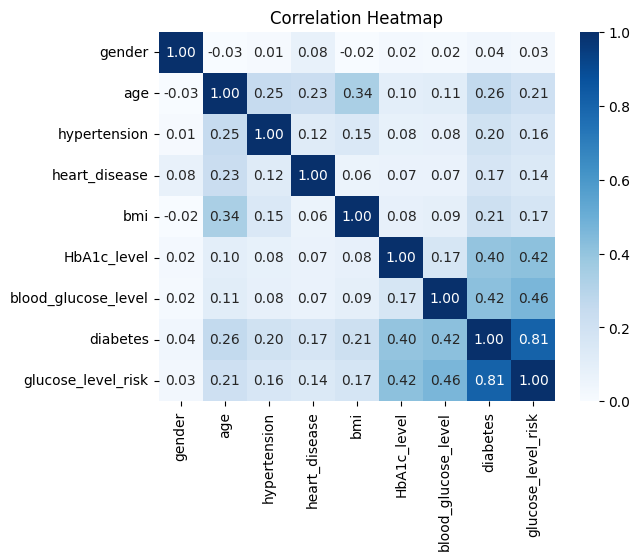

In [23]:
# correlation heatmap with pearson
fig, ax = plt.subplots()
sns.heatmap(df_c.corr(method='pearson', numeric_only=True), annot=True, cmap='Blues', vmin=0, vmax=1, fmt='.2f')

plt.title('Correlation Heatmap')
plt.show()

Based on the correlation matrix above, no features are negatively correlated to diabetes, and the values are all above 0,15. This signifies that all features might positively contribute/correlate to diabetes, although some of them (age, hypertension, heart disease, and body mass index) have a significantly lower coefficient than the other three (HBA1c level, blood glucose level, and their derivative which is glucose level risk).

# Preprocessing and First Iteration

## Train-Test Split

In [24]:
# split data into features & target
target = 'diabetes'
features = df.loc[:, df.columns != target].columns

X_data = df[features]
y_data = df[target]

# split data by 75:25 for train:test
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.25, random_state=random_state, stratify=y_data)

# check amount of data on train and test
print('train data count =', X_train.shape[0])
print('test data count  =', X_test.shape[0])

train data count = 74986
test data count  = 24996


## Handling Missing Values and Duplicated Data
From `.info()` method, there are no columns detected with a null value.

Although duplicated data are usually removed in analysis and modeling, based on the features on the dataset duplicates are bound to happen since it is possible for different patients to have the same values on all features on the dataset. Therefore, no duplicates should be removed.

## Transformation and Encoding Pipeline

In the first iteration of the model, we pick 2 features that can be assumed to have a correlation with diabetes. Although HbA1c and blood glucose level have a quite significant correlation, these features are already represented by `glucose_level_risk` and thus not included in this current iteration. `age` is also included as it have a relatively high correlation compared to other features.

To simplify features for some models, age is to be standardized with `StandardScaler`. `glucose_level_risk` does not need to be transformed since it is already in the form of binary data.

In [25]:
# use StandardScaler for other numerical columns (other than binary)
age_transformer = Pipeline(
    steps=[
        ('scaler', StandardScaler()),
    ]
)

# finalize column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('age', age_transformer, ['age']),
        ('pass', 'passthrough', ['glucose_level_risk'])
    ],
)

## Handle Imbalances
Based on the target mean value, there are only around ~8% of patients diagnosed with diabetes in the whole dataset, compared to the ~92% of patients not diagnosed with diabetes. This imbalance might lead to an underperforming model, especially when the necessity to predict the minority (patients with diabetes) is greater than to predict the majority. 


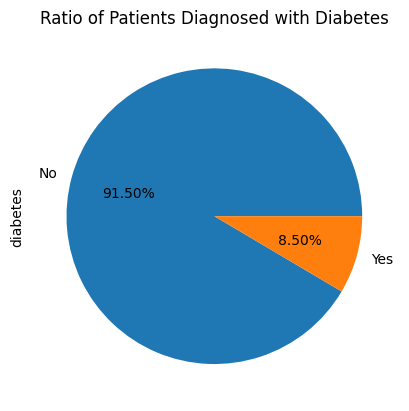

In [26]:
# check ratio of diabetes
y_train.groupby(y_train).size().plot.pie(labels=['No', 'Yes'], autopct='%.2f%%')

plt.title('Ratio of Patients Diagnosed with Diabetes')
plt.show()

In [27]:
# check amount of diabetes patients on y train
y_train[y_train == 1].count()

6375

Since there are already 6800 records of patients with diabetes on the train data, rather than using oversampling to inflate the numbers of patients with diabetes, we can use undersampling to reduce the numbers of patients not diagnosed with diabetes to handle the class imbalance.

In [28]:
rus = RandomUnderSampler(random_state=random_state)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

X_train_resampled.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,glucose_level_risk
count,12750.000000,12750.000000,12750.000000,12750.000000,12750.000000,12750.000000,12750.000000
mean,50.703068,0.155059,0.089647,29.423035,6.168063,163.824863,0.333098
std,21.575287,0.361975,0.285687,7.442290,1.272739,56.811193,0.471340
min,0.080000,0.000000,0.000000,10.980000,3.500000,80.000000,0.000000
25%,37.000000,0.000000,0.000000,25.872500,5.700000,130.000000,0.000000
50%,54.000000,0.000000,0.000000,27.320000,6.100000,155.000000,0.000000
75%,68.000000,0.000000,0.000000,32.720000,6.600000,200.000000,1.000000
max,80.000000,1.000000,1.000000,88.760000,9.000000,300.000000,1.000000


In [29]:
# check average of target to see distribution ratio
y_train_resampled.mean()

0.5

## Metrics, Cross Validation and Model Comparisons

Although a high accuracy, precision, and recall score on a model would be ideal, recall score would be the priority on model evaluation, since we would like to prevent the case of False Negative (patients that are predicted without diabetes but actually are diagnosed with diabetes) as much as possible.

In [30]:
def cross_validation(features, target, models, preproc, cv):
    model_name = []

    cv_accuracy_mean = []
    cv_accuracy_std = []
    training_accuracy = []

    cv_precision_mean = []
    cv_precision_std = []
    training_precision = []

    cv_recall_mean = []
    cv_recall_std = []
    training_recall = []
    
    for name, model in models:
    
        pipeline = Pipeline([
            ('preprocessor', preproc),
            ('model', model)
        ]) 
        model_name.append(name)

        #scoring
        scoring= ['recall', 'accuracy', 'precision']

        # test
        cv_score = cross_validate(pipeline, features, target, scoring=scoring, cv=cv, n_jobs=-1)

        cv_accuracy_mean.append(cv_score['test_accuracy'].mean())
        cv_accuracy_std.append(cv_score['test_accuracy'].std())

        cv_precision_mean.append(abs(cv_score['test_precision']).mean())
        cv_precision_std.append(abs(cv_score['test_precision']).std())

        cv_recall_mean.append(abs(cv_score['test_recall']).mean())
        cv_recall_std.append(abs(cv_score['test_recall']).std())

        # training
        pipeline.fit(features, target)
        y_pred = pipeline.predict(features)
        training_accuracy.append(accuracy_score(target, y_pred))
        training_precision.append(precision_score(target, y_pred))
        training_recall.append(recall_score(target, y_pred))
    
    return pd.DataFrame({
        'Model': model_name,
        'Training Accuracy': training_accuracy,
        'CV Accuracy (mean)': cv_accuracy_mean,
        'CV Accuracy (std)' : cv_accuracy_std,
        'Training Precision' : training_precision,
        'CV Precision (mean)': cv_precision_mean,
        'CV Precision (std)': cv_precision_std,
        'Training Recall' : training_recall,
        'CV Recall (mean)' : cv_recall_mean,
        'CV Recall (std)' : cv_recall_std
    })

In [31]:
models = [
    ['Decision Tree', DecisionTreeClassifier(random_state=random_state)],
    ['Random Forest', RandomForestClassifier(random_state=random_state)],
    ['Logistic Regression', LogisticRegression(random_state=random_state, solver='sag')],
    ['KNN', KNeighborsClassifier()],
    ['XGBoost', XGBClassifier()],
]

cv_result = cross_validation(X_train_resampled, y_train_resampled, models, preprocessor, 5)
cv_result

,Model,Training Accuracy,CV Accuracy (mean),CV Accuracy (std),Training Precision,CV Precision (mean),CV Precision (std),Training Recall,CV Recall (mean),CV Recall (std)
0,Decision Tree,0.838510,0.836235,0.001230,0.937906,0.928978,0.009279,0.725020,0.728314,0.008280
1,Random Forest,0.838510,0.834980,0.002570,0.937906,0.917025,0.015875,0.725020,0.737098,0.010906
2,Logistic Regression,0.827765,0.826824,0.006437,0.886873,0.887203,0.014463,0.751373,0.749176,0.007896
3,KNN,0.833098,0.833098,0.001866,1.000000,1.000000,0.000000,0.666196,0.666196,0.003732
4,XGBoost,0.838510,0.836471,0.001446,0.937906,0.924424,0.009357,0.725020,0.733020,0.006703


# Second Iteration

On the second iteration, we include `bmi`, `hypertension`, and `heart_disease` in the model to see if the predictive power are significantly improved with the inclusion of those features.

In [32]:
# use StandardScaler for numerical columns (other than binary)
num_cols = ['age', 'bmi']
num_transformer = Pipeline(
    steps=[
        ('scaler', StandardScaler()),
    ]
)

# finalize column transformer
preprocessor_2 = ColumnTransformer(
    transformers=[
        ('pass', 'passthrough', ['hypertension', 'heart_disease', 'glucose_level_risk']),
        ('num', num_transformer, num_cols),
    ],
)

In [33]:
cv_result = cross_validation(X_train_resampled, y_train_resampled, models, preprocessor_2, 5)
cv_result

,Model,Training Accuracy,CV Accuracy (mean),CV Accuracy (std),Training Precision,CV Precision (mean),CV Precision (std),Training Recall,CV Recall (mean),CV Recall (std)
0,Decision Tree,0.971922,0.824000,0.005304,0.991987,0.836626,0.010755,0.951529,0.805490,0.004437
1,Random Forest,0.971843,0.837961,0.007508,0.988947,0.861130,0.016814,0.954353,0.806431,0.007057
2,Logistic Regression,0.863608,0.863216,0.004370,0.919623,0.919433,0.011483,0.796863,0.796392,0.004563
3,KNN,0.883765,0.846039,0.005621,0.924077,0.880745,0.010382,0.836235,0.800627,0.006681
4,XGBoost,0.899843,0.857098,0.004564,0.945474,0.895216,0.015889,0.848627,0.809412,0.010202


Turns out across the board on every model tested, both training and CV scores are significantly increased compared to the first iteration, especially on recall score.

# Third Iteration

For the third iteration, we shall compare whether using the derived feature `glucose_level_risk` as in the second iteration are actually better than using the original feature which is `HbA1c_level` and `blood_glucose_level`.

In [34]:
# use StandardScaler for numerical columns (other than binary)
num_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
num_transformer = Pipeline(
    steps=[
        ('scaler', StandardScaler()),
    ]
)

# finalize column transformer
preprocessor_3 = ColumnTransformer(
    transformers=[
        ('pass', 'passthrough', ['hypertension', 'heart_disease']),
        ('num', num_transformer, num_cols),
    ],
)

In [35]:
cv_result = cross_validation(X_train_resampled, y_train_resampled, models, preprocessor_3, 5)
cv_result

,Model,Training Accuracy,CV Accuracy (mean),CV Accuracy (std),Training Precision,CV Precision (mean),CV Precision (std),Training Recall,CV Recall (mean),CV Recall (std)
0,Decision Tree,0.997412,0.875137,0.004550,0.999213,0.877481,0.011284,0.995608,0.872314,0.006321
1,Random Forest,0.997333,0.896941,0.005091,0.997958,0.894935,0.007659,0.996706,0.899608,0.010822
2,Logistic Regression,0.883451,0.882824,0.006345,0.886482,0.885515,0.007621,0.879529,0.879373,0.005981
3,KNN,0.919529,0.882980,0.001799,0.916524,0.883282,0.007983,0.923137,0.882824,0.012672
4,XGBoost,0.946588,0.902118,0.006965,0.945819,0.899915,0.008192,0.947451,0.904941,0.009598


As shown in the table above, recall scores are improved compared to the second iteration, which shows that using the original feature might be a better choice rather than using the derived feature on the model.

# Fourth Iteration

Just to add another comparison, in the fourth iteration we include both the derived and original features regarding to glucose level. Note that this might introduce multicolinearity on linear models, although on classification models it might not be a bigger problem.

In [36]:
# use StandardScaler for numerical columns (other than binary)
num_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
num_transformer = Pipeline(
    steps=[
        ('scaler', StandardScaler()),
    ]
)

# finalize column transformer
preprocessor_4 = ColumnTransformer(
    transformers=[
        ('pass', 'passthrough', ['hypertension', 'heart_disease', 'glucose_level_risk']),
        ('num', num_transformer, num_cols),
    ],
)

In [37]:
cv_result = cross_validation(X_train_resampled, y_train_resampled, models, preprocessor_4, 5)
cv_result

,Model,Training Accuracy,CV Accuracy (mean),CV Accuracy (std),Training Precision,CV Precision (mean),CV Precision (std),Training Recall,CV Recall (mean),CV Recall (std)
0,Decision Tree,0.997412,0.874510,0.004848,0.999213,0.876512,0.011597,0.995608,0.872157,0.008090
1,Random Forest,0.997333,0.896549,0.003131,0.997646,0.896065,0.006146,0.997020,0.897255,0.008044
2,Logistic Regression,0.887686,0.888000,0.003469,0.908715,0.908931,0.004027,0.861961,0.862431,0.006517
3,KNN,0.922510,0.887294,0.001833,0.919744,0.887745,0.007639,0.925804,0.886902,0.010279
4,XGBoost,0.949961,0.902039,0.006082,0.947295,0.898563,0.008559,0.952941,0.906510,0.008796


While there are a very slight improvement on some scores, other scores are actually lower compared to the third iteration, which suggests that using the original features should be enough and the derived feature should not be used in modeling.


## Iterations Conclusion

Comparing all four iterations, we can see that the third iteration would be the ideal conditions to create the model, where the features used are all of the original features excluding gender, which have a very low correlation with all other features and also the target.

On the result of the third iteration, we can also see that there are two models that have a relatively better score compared to others, which is Random Forest and XGBoost. To improve both models, we shall proceed to tune model hyperparameters.

# Hyperparameter Tuning

In [38]:
# combine preprocessing and classifier into a single pipeline 
rfc = Pipeline(
    steps=[
        ('preprocessor', preprocessor_3), 
        ('classifier', RandomForestClassifier(random_state=random_state))
    ]
)

# hyperparameter combinations
param_grid = {
    'classifier__n_estimators' : range(100, 1001, 100),
    'classifier__criterion' : ['gini', 'entropy'],
    'classifier__max_depth' : range(2, 21, 2),
    'classifier__max_features' : ['sqrt', 'log2', None],
    'classifier__min_samples_split' : [2, 5, 10],
    'classifier__min_samples_leaf' : [1, 2, 4],
}

# iterate with Randomized Search
rs = RandomizedSearchCV(rfc, param_grid, n_iter=100, n_jobs=-1, cv=5, scoring='recall', random_state=random_state)
rs.fit(X_train_resampled, y_train_resampled)

# print the best hyperparameters
print('Best hyperparameters using randomized search:', rs.best_params_)

Best hyperparameters using randomized search: {'classifier__n_estimators': 200, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 1, 'classifier__max_features': None, 'classifier__max_depth': 6, 'classifier__criterion': 'entropy'}


In [39]:
rf_best_clf = RandomForestClassifier(random_state=random_state, n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=None, max_depth=6, criterion='entropy') 

# best pipeline
rf_best = Pipeline( 
    steps = [ 
        ('preprocessor', preprocessor_3),
        ('classifier', rf_best_clf)
    ]
)

# fit pipeline with resampled train data
rf_best.fit(X_train_resampled, y_train_resampled)

# evaluate model
y_train_pred = rf_best.predict(X_train_resampled)
y_test_pred = rf_best.predict(X_test)

# main model evaluation: recall
print('Recall score data TRAIN :', round(recall_score(y_train_resampled, y_train_pred)*100, 3), '%')
print('Recall score data TEST  :', round(recall_score(y_test, y_test_pred)*100, 3), '%')

# other scores
print('\nOther Scores (based on test data):\n')
print('Accuracy score :', round(accuracy_score(y_test, y_test_pred)*100, 3), '%')
print('F-1 score :', round(f1_score(y_test, y_test_pred)*100, 3), '%')
print('Precision score :', round(precision_score(y_test, y_test_pred)*100, 3), '%')
print('Jaccard score :', round(jaccard_score(y_test, y_test_pred)*100, 3), '%')
print('Log Loss :', (log_loss(y_test, y_test_pred)))

Recall score data TRAIN : 95.122 %
Recall score data TEST  : 95.388 %

Other Scores (based on test data):

Accuracy score : 84.197 %
F-1 score : 50.65 %
Precision score : 34.479 %
Jaccard score : 33.913 %
Log Loss : 5.695808564850887


Confusion Matrix:


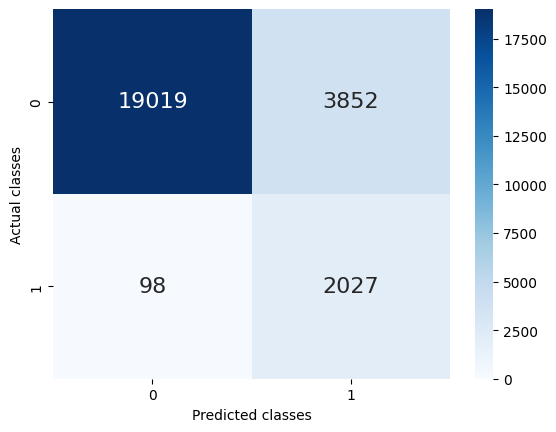

In [40]:
print("Confusion Matrix:")
sns.heatmap(confusion_matrix(y_test,y_test_pred), cmap='Blues', annot = True, annot_kws={"size": 16}, fmt="d", vmin=0) 
plt.xlabel('Predicted classes')
plt.ylabel('Actual classes')
plt.show()

Base Model Comparison

In [41]:
rf_best_clf = RandomForestClassifier(random_state=random_state)

# best pipeline
rf_best = Pipeline( 
    steps = [ 
        ('preprocessor', preprocessor_3),
        ('classifier', rf_best_clf)
    ]
)

# fit pipeline with resampled train data
rf_best.fit(X_train_resampled, y_train_resampled)

# evaluate model
y_train_pred = rf_best.predict(X_train_resampled)
y_test_pred = rf_best.predict(X_test)

# main model evaluation: recall
print('Recall score data TRAIN :', round(recall_score(y_train_resampled, y_train_pred)*100, 3), '%')
print('Recall score data TEST  :', round(recall_score(y_test, y_test_pred)*100, 3), '%')

# other scores
print('\nOther Scores (based on test data):\n')
print('Accuracy score :', round(accuracy_score(y_test, y_test_pred)*100, 3), '%')
print('F-1 score :', round(f1_score(y_test, y_test_pred)*100, 3), '%')
print('Precision score :', round(precision_score(y_test, y_test_pred)*100, 3), '%')
print('Jaccard score :', round(jaccard_score(y_test, y_test_pred)*100, 3), '%')
print('Log Loss :', (log_loss(y_test, y_test_pred)))

Recall score data TRAIN : 99.671 %
Recall score data TEST  : 90.165 %

Other Scores (based on test data):

Accuracy score : 89.946 %
F-1 score : 60.394 %
Precision score : 45.403 %
Jaccard score : 43.26 %
Log Loss : 3.623687828726652


Confusion Matrix:


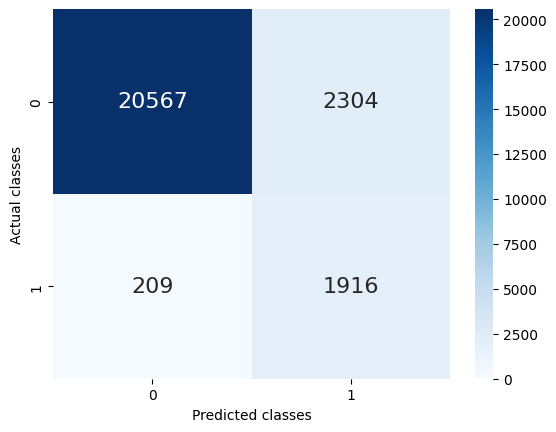

In [42]:
print("Confusion Matrix:")
sns.heatmap(confusion_matrix(y_test,y_test_pred), cmap='Blues', annot = True, annot_kws={"size": 16}, fmt="d", vmin=0) 
plt.xlabel('Predicted classes')
plt.ylabel('Actual classes')
plt.show()

# Conclusions

Although the model shaped by hyperparameter tuning have a high enough recall and accuracy score while preventing overfitting compared to the base model, its precision score is noticably low. Depending on the use case, this might not be a huge concern since the amount of False Negatives (predicted 0 or non-diabetes, actual 1 or diabetes) are minimalized on the model.

Since the split between the predicted class of 1 (predicted with diabetes) which are actually diagnosed with diabetes (1) or not (0 or False Positive) are still 1:2, there will still be more patients that does not actually have diabetes compared to patients that actually have diabetes in that predicted class. If this model was to be deployed, more thorough physical examinations should still be conducted on patients predicted with diabetes.